# Closed system simulation with experimental data markers

In this simulation we have a system of 5 liters in which we start with Next = 1000, some Nint (measured) of some mass (m). After this we "feed" for a period of 3.5 days, i.e. solve the "feeding" part of the simulation. After that, we add 1000 uM to the last value of Next and keep "feeding". After one duration (7 days) we reset the water, mass and the amplitude to the beginning of the first cycle. The only difference from the t_0 is the Nint which is accumulating all the effects through the time. The mass is reset to m_0 and Next is reset to 1000 ppm (per something per something)


In [1]:
# N_simulation
from __future__ import division
import numpy as np
from scipy.integrate import odeint
from matplotlib.pylab import *
import matplotlib.pyplot as plt
import pandas as pd # to read excel
%matplotlib inline

# from datetime import datetime

In [2]:
# During feeding we have N_ext concentration and it changes due to growth for some time
def N_feeding(x,t):
    """ See powerpoint with the formulae 
    During feeding we supply an initially high Next and let the algae to consume it 
    """
    Next = x[0] # units: [umol N/l]
    NH4 = x[1] # units: [umol N/g DW]
    Nint = x[2] # units: [% g N/g DW]
    m = x[3] # units: [g DW/l]
    umol_to_percent_DW = 100*14e-6 #[% g N/umol N]
    Norgmax = Nintmax - umol_to_percent_DW * NH4max # units: [% g N/umol N]
    Norgmin = Nintmin - umol_to_percent_DW * NH4min # units: [% g N/umol N]
    Norg = Nint - umol_to_percent_DW * NH4 # units: [% g N/umol N]
    Neff = (Norgmax - Norg)/(Norgmax - Norgmin) # units: [-]
    # uN = Vmax * Next / (Ks + Next) # units: [umol N/g DW/h]
    fNH4 = (NH4max - NH4)/(NH4max - NH4min) # units: [-]
    uN = (Vassim + fNH4 * (Vmax - Vassim)) * Next / (Ks + Next) # units: [umol N/g DW/h]
    # fN = (Nint - Nintmin)/(KN + (Nint - Nintmin)) # units: [-]
    fN = ((Norg - Norgmin)/Norg) / ((Norgmax - Norgmin)/Norgmax) # units: [-]
    # fpr = ((pr - prmin)/pr) / ((prmax - prmin)/prmax) # units: [-]
    fD =  Kd**2/(Kd**2 + m**2) #test - density effect
    dNextdt = -Neff * uN * m - dNextoutdt * Next + dNextindt # units: [umol N/l/h]
    dNH4dt = Neff * (uN - Vassim * NH4 / (KNH4 + NH4)) # units: [umol N/g DW/h]
    dNintdt = (1-0.06) * umol_to_percent_DW * Neff * Vassim * NH4 / (KNH4 + NH4) - Nint * miu * fN * fD  #units: [%g N/g DW/h] #organic N
    dmdt = miu * fN * m * fD - dmoutdt #units: [g DW/l/h]
    
    return [dNextdt,dNH4dt,dNintdt,dmdt]

def N_growing(x,t):
    """ See powerpoint with the formulae 
    ! we assume during growing that there is Next = 0 
    """

    Next = 0 # units: [umol N/l]
    NH4 = x[1] # units: [umol N/g DW]
    Nint = x[2] # units: [% g N/g DW]
    m = x[3] # units: [g DW/l]
    umol_to_percent_DW = 100*14e-6 #[% g N/umol N]
    Norgmax = Nintmax - umol_to_percent_DW * NH4max # units: [% g N/umol N]
    Norgmin = Nintmin - umol_to_percent_DW * NH4min # units: [% g N/umol N]
    Norg = Nint - umol_to_percent_DW * NH4 # units: [% g N/umol N]
    Neff = (Norgmax - Norg)/(Norgmax - Norgmin) # units: [-]
    # uN = Vmax * Next / (Ks + Next) # units: [umol N/g DW/h]
    fNH4 = (NH4max - NH4)/(NH4max - NH4min) # units: [-]
    uN = (Vassim + fNH4 * (Vmax - Vassim)) * Next / (Ks + Next) # units: [umol N/g DW/h]
    # fN = (Nint - Nintmin)/(KN + (Nint - Nintmin)) # units: [-]
    fN = ((Norg - Norgmin)/Norg) / ((Norgmax - Norgmin)/Norgmax) # units: [-]
    # fpr = ((pr - prmin)/pr) / ((prmax - prmin)/prmax) # units: [-]
    fD =  Kd**2/(Kd**2+m**2) #test - density effect
    dNextdt = 0 # units: [umol N/l/h]
    dNH4dt = Neff * (uN - Vassim) # units: [umol N/g DW/h]
    dNintdt = (1-0.06) * umol_to_percent_DW * Neff * Vassim - Nint * miu * fN * fD  #units: [%g N/g DW/h] #organic N
    dmdt = miu * fN * m * fD - dmoutdt #units: [g DW/l/h]
    
    return [dNextdt,dNH4dt,dNintdt,dmdt]

def plot_result(t_model,Next_model,NH4_model,Nint_model,m_model,Nint=None,tNint=None,m=None,tm=None,Next=None,tNext=None,NH4=None,tNH4=None):
    """ Plot time series of the results """
    fig,ax = plt.subplots(4,1,sharex=True,figsize=(12,10))
    ax[0].plot(t_model,Next_model,'r.--')
    if Next is not None:
        ax[0].plot(tNext[::],Next[::],'s')
    ax[0].set_ylabel('Next \n [umol / l]')
    # plt.axis([0, 180, 0, 430])
    ax[1].plot(t_model,NH4_model,'gx--')
    ax[1].set_ylabel('NH4 \n [% umol N / g DW]')
    if NH4 is not None:
        ax[1].plot(NH4[::],NH4[::],'s')
    # plt.axis([0, 180, 2.0, 4.0])   
    ax[2].plot(t_model,Nint_model,'gx--')
    ax[2].set_ylabel('Nint \n [% g N / g DW]')
    if Nint is not None:
        ax[2].plot(tNint[::],Nint[::],'s')
    # plt.axis([0, 180, 2.0, 4.0])
    ax[3].plot(t_model,m_model,'b+--')
    ax[3].set_xlabel('time [hours]')
    if m is not None:
        ax[3].plot(tm[::],m[::],'s')
    ax[3].set_ylabel('m \n [g DW / l]')
    # plt.axis([0, 180, 0.03, 0.3])
    # plot_result(np.hstack(T),np.hstack(NEXT),np.hstack(NINT),np.hstack(M))
    # ax[0].plot(df.iloc[:][1::2],df.iloc[:][2::2],'--s')


In [3]:
## Read the inputs file, model parameters


In [4]:
xl = pd.ExcelFile('../data/input_format.xlsx')

df1 = xl.parse('Parameters',header=None)
df2 = xl.parse('500.3.5.168')#header=None)


# which parameters? and values we read? if you want to print, uncomment:
# print(df.iloc[:][0],df.iloc[:][1])

# assigmment of parameters to values: 
for key,val in zip(df1.iloc[:][0],df1.iloc[:][1]):
    exec(key + '=val')
    print(key,val)

dNextoutdt 0.03
dNextindt 0.0
dmoutdt 0.0
miu 0.014583333333333332
Nintmax 4.23
Nintmin 1.0
NH4max 100.0
NH4min 0.0
KNH4 10.0
KN 2.0
Ks 14.0
Vmax 146.0
Vassim 60.0
Next0 0.0
NH40 0.0
Nint0 1.85
m0 0.15
Amplitude 500.0
Duration 7.0
Period 3.5
Kd 0.25
Nintcrit 3.0


In [5]:
df2.head()

,day i,day f,sleeve,parameter,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,22.07.19,12.08.19,1.0,Time,25.07.19 10:00,29.07.19 20:30,01.08.19 12:45,05.08.19 16:15,06.08.19 12:00,07.08.19 09:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,Next,NaN,170.705,20.6988,9.78313,246.388,175.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,Time,22.07.19 15:00,23.07.19 14:00,29.07.19 21:45,04.08.19 13:30,05.08.19 17:15,08.08.19 09:30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,Nint,1.5702,2.99976,2.12817,2.60004,2.39346,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,Time,22.07.19 15:00,23.07.19 14:00,23.07.19 14:01,24.07.19 09:30,25.07.19 10:00,28.07.19 09:30,...,04.08.19 13:30,04.08.19 13:31,05.08.19 17:15,05.08.19 17:16,06.08.19 12:30,07.08.19 13:00,08.08.19 09:30,08.08.19 09:31,11.08.19 09:30,12.08.19 13:00


In [6]:
df2.tail()

,day i,day f,sleeve,parameter,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
75,NaN,NaN,NaN,Next,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,NaN,NaN,Time,06.05.19 13:30,13.05.19 13:30,20.05.19 12:00,27.05.19 12:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,Nint,2.05476,1.51899,2.40742,3.11206,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,Time,06.05.19 13:30,13.05.19 12:00,13.05.19 12:01,20.05.19 12:00,20.05.19 12:01,27.05.19 12:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,m,0.147,0.492,0.153,0.324,0.15,0.243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# find out how many experiments are in the file
n_exp = df2['day i'].dropna().shape[0] # number of items that have day i property and not NaN

# it should be equal to the number of day f - just for a test. will pop an error if the file is corrupted
assert (n_exp == df2['day f'].dropna().shape[0])

print('N of experiments = {}'.format(n_exp))

N of experiments = 12


In [8]:
day_i = df2['day i'].dropna()
day_i.astype('S')

0     b'22.07.19'
7     b'22.07.19'
14    b'22.07.19'
21    b'22.07.19'
28    b'22.07.19'
35    b'22.07.19'
42    b'22.07.19'
49    b'22.07.19'
56    b'22.07.19'
62    b'06.05.19'
68    b'06.05.19'
74    b'06.05.19'
Name: day i, dtype: bytes64

In [9]:
# find out the sleeve number in each experiment
sleeves = df2['sleeve'].dropna().astype(int)
for s in sleeves:
    print('sleeve {}'.format(s))

sleeve 1
sleeve 2
sleeve 3
sleeve 4
sleeve 5
sleeve 6
sleeve 7
sleeve 8
sleeve 9
sleeve 7
sleeve 8
sleeve 9


In [10]:
ind_Nint = df2.index[df2['parameter'] == 'Nint'] # find index of the Nint rows
print(ind_Nint) # print it for the reference, these are rows 2, 6 and 10

# small test
assert(len(ind_Nint) == n_exp) # if we found less Nint than experiments, then something is wrong


df2.iloc[ind_Nint[1],4:].dropna() # take the 2nd element of that index, i.e. 2nd experiment and show the data:

Int64Index([3, 10, 17, 24, 31, 38, 45, 52, 59, 65, 71, 77], dtype='int64')


Unnamed: 4      1.5702
Unnamed: 5     2.93388
Unnamed: 6        2.05
Unnamed: 7     2.50798
Unnamed: 8     2.25557
Unnamed: 9     3.00527
Unnamed: 10    2.45769
Name: 10, dtype: object

In [11]:
ind_Next = df2.index[df2['parameter'] == 'Next'] # find index of the Next 
Next_measurement_times = pd.to_datetime(df2.iloc[ind_Next[0]-1,4:].dropna(),dayfirst=True)
print(Next_measurement_times)

Unnamed: 4    2019-07-25 10:00:00
Unnamed: 5    2019-07-29 20:30:00
Unnamed: 6    2019-08-01 12:45:00
Unnamed: 7    2019-08-05 16:15:00
Unnamed: 8    2019-08-06 12:00:00
Unnamed: 9    2019-08-07 09:00:00
Unnamed: 10   2019-08-08 10:00:00
Unnamed: 11   2019-08-11 09:00:00
Unnamed: 12   2019-08-12 13:00:00
Name: 0, dtype: datetime64[ns]


No handles with labels found to put in legend.


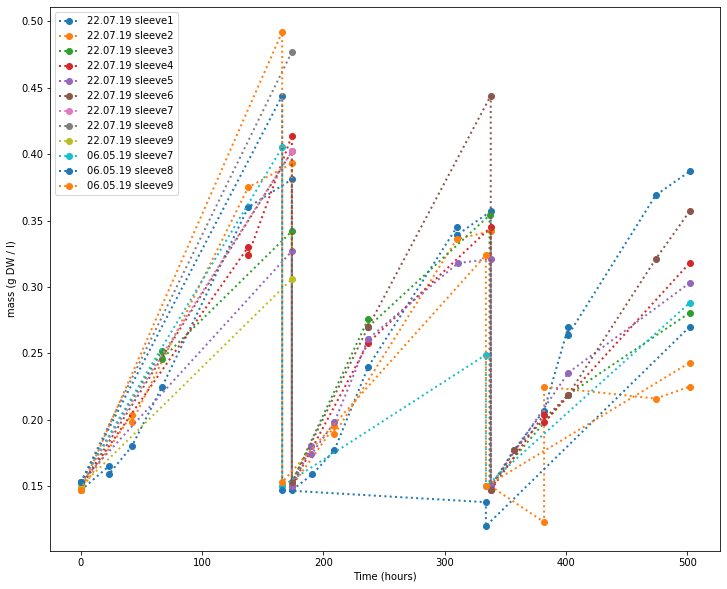

In [12]:
# plot all sleeves data
ind_m = df2.index[df2['parameter'] == 'm'] # find index of the mass was measured (this is the only data available so far)
# small test
assert(len(ind_m) == n_exp) # if we found less Nint than experiments, then something is wrong


fig,ax = plt.subplots(figsize=(12,10))

plt.legend()
plt.xlabel('Time')
plt.ylabel('mass');

m_all, m_times_all, Nint_all, Nint_times_all, Next_all, Next_times_all = [], [], [], [], [], []

for counter,value in enumerate(ind_m):
    m = df2.iloc[value,4:]
    val = []
    for number in m:
        a=~np.isnan(number)
        val.append(a)
    m = df2.iloc[value,4:][val] #'value' gives row number, '4:' goes column by column starting at 4.
    m_measurement_times = pd.to_datetime(df2.iloc[value-1,4:][val],dayfirst=True)
    hours = pd.Series((m_measurement_times - m_measurement_times[0]).astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    # print(counter, label)
    ax.plot(hours,m,':o',label=label,lw=2)
    
    for sample in m:
        m_all.append(sample)
    
    for h in hours:
        m_times_all.append(h)
        
ax.legend()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('mass (g DW / l)');

No handles with labels found to put in legend.


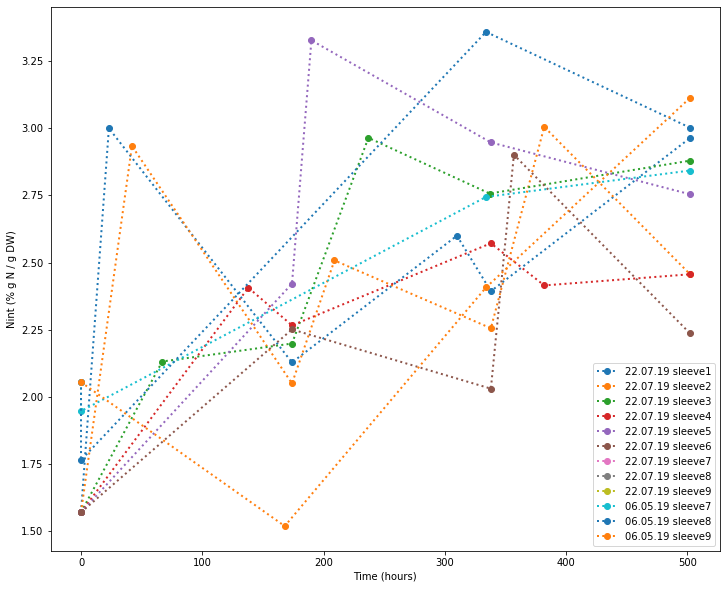

In [13]:
# plot all sleeves data
ind_Nint = df2.index[df2['parameter'] == 'Nint'] # find index of the mass was measured (this is the only data available so far)
# small test
assert(len(ind_Nint) == n_exp) # if we found less Nint than experiments, then something is wrong

fig,ax = plt.subplots(figsize=(12,10))

plt.legend()
plt.xlabel('Time')
plt.ylabel('Nint');

Nint_all, Nint_times_all = [], []
for counter,value in enumerate(ind_Nint):
    Nint = df2.iloc[value,4:] #'value' gives row number, '4:' goes column by column starting at 4.
    val = []
    for number in Nint:
        a=~np.isnan(number)
        val.append(a)
    Nint = df2.iloc[value,4:][val]
    Nint_measurement_times = pd.to_datetime(df2.iloc[value-1,4:],dayfirst=True)
    hours = pd.Series((Nint_measurement_times - Nint_measurement_times[0])[val].astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    # print(counter, label)
    ax.plot(hours,Nint,':o',label=label,lw=2)
    
    for sample in Nint:
        Nint_all.append(sample)
    
    for h in hours:
        Nint_times_all.append(h)
        
ax.legend()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Nint (% g N / g DW)');

No handles with labels found to put in legend.


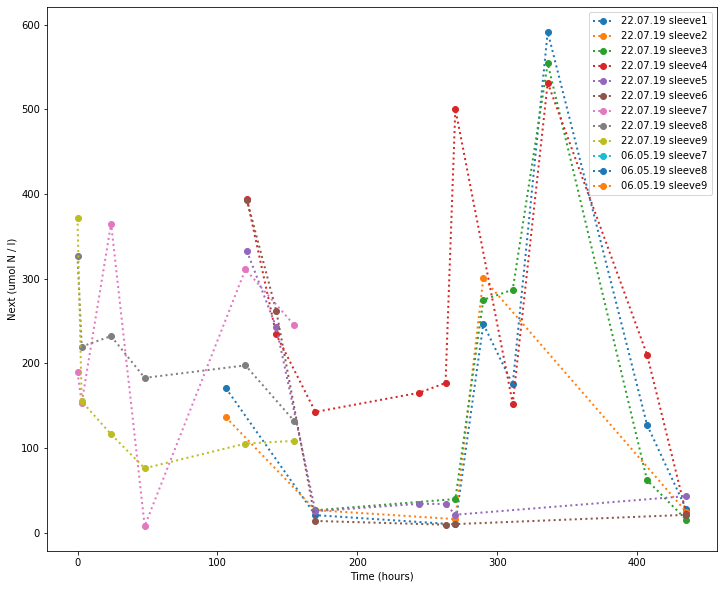

In [14]:
# plot all sleeves data
ind_Next = df2.index[df2['parameter'] == 'Next'] # find index of the mass was measured (this is the only data available so far)
# small test
assert(len(ind_Next) == n_exp) # if we found less Nint than experiments, then something is wrong

fig,ax = plt.subplots(figsize=(12,10))

plt.legend()
plt.xlabel('Time')
plt.ylabel('Next');

Next_all, Next_times_all = [], []
for counter,value in enumerate(ind_Next):
    Next = df2.iloc[value,4:] #'value' gives row number, '4:' goes column by column starting at 4.
    val = []
    for number in Next:
        a=~np.isnan(number)
        val.append(a)
    Next = df2.iloc[value,4:][val]
    Next_measurement_times = pd.to_datetime(df2.iloc[value-1,4:],dayfirst=True)
    hours = pd.Series((Next_measurement_times - Next_measurement_times[0])[val].astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    # print(counter, label)
    ax.plot(hours,Next,':o',label=label,lw=2)
    
    for sample in Next:
        Next_all.append(sample)
    
    for h in hours:
        Next_times_all.append(h)
        
ax.legend()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Next (umol N / l)');

In [15]:
# now combine the two:
# decide how many cycles you want, e.g. 10 days, with a daily feeding
NEXT, NH4, NINT, M, T = [],[],[],[],[]

n_days = Duration*3

for hour in np.arange(0,n_days*24,Period*24):
    print(hour)
    
    if hour == 0:
        print('Starting point')
        Nint_0 = Nint0
        NH4_0 = NH40
        m_0 = m0
        Next_0 = Amplitude
    
    if hour > 0 and np.mod(hour,Period*24) == 0:
        if np.mod(hour,Duration*24) == 0:
            print('Duration')
            # reset everything, except Nint and NH4
            Nint_0 = NINT[-1][-1]
            NH4_0 = NH4[-1][-1]
            Next_0 = Amplitude
            m_0 = m0
        else:    
            # period passed, not Duration
            # add amplitude, keep going 
            print('Period')
            Next_0 = NEXT[-1][-1] + Amplitude
            NH4_0 = NH4[-1][-1]
            Nint_0 = NINT[-1][-1]
            m_0 = M[-1][-1]

        
    # setup initial conditions
    x0 = [Next_0,NH4_0,Nint_0,m_0]
    
    t = linspace(hour,hour+Period*24)
    x = odeint(N_feeding,x0,t)

    NEXT.append(x[: , 0])
    NH4.append(x[: , 1])
    NINT.append(x[: , 2])
    M.append(x[: , 3])
    T.append(t)
    
    t_model = np.hstack(T)
    Next_model = np.hstack(NEXT)
    NH4_model = np.hstack(NH4)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)

0.0
Starting point
84.0
Period
168.0
Duration
252.0
Period
336.0
Duration
420.0
Period


## Read the experimental data from the same file, second sheet

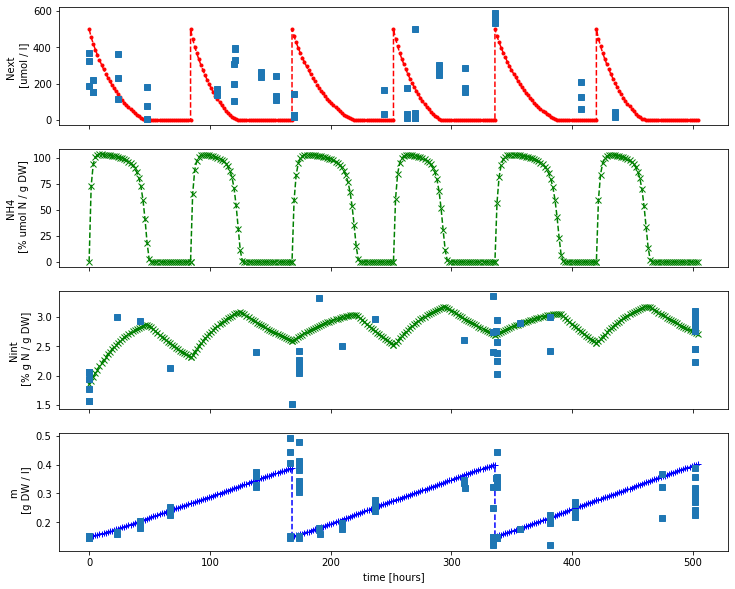

In [16]:
plot_result(t_model,Next_model,NH4_model,Nint_model,m_model,Nint=Nint_all,tNint=Nint_times_all,m=m_all,tm=m_times_all,Next=Next_all,tNext=Next_times_all)

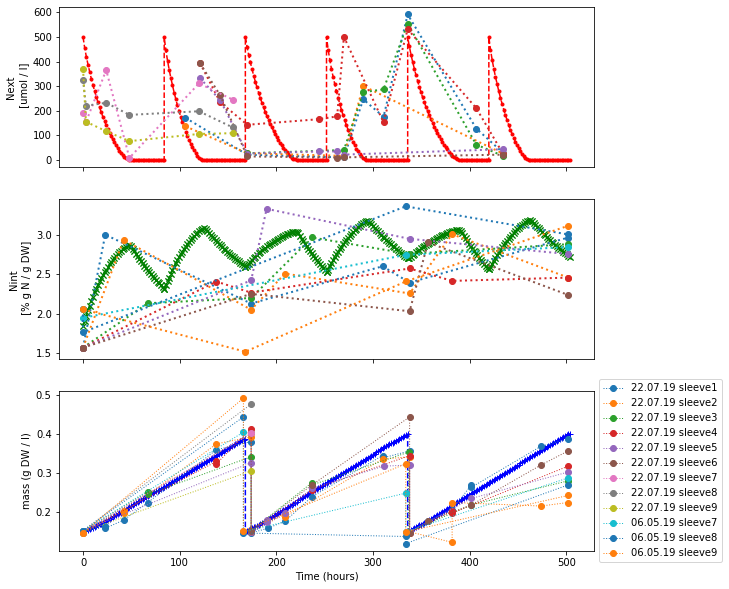

In [17]:
# still need to add NH4

# New, manual plot, not a function.

fig,ax = plt.subplots(3,1,sharex=True,figsize=(12,10))
ax[0].plot(t_model,Next_model,'r.--')
ax[0].set_ylabel('Next \n [umol / l]')
# plt.axis([0, 180, 0, 430])
ax[1].plot(t_model,Nint_model,'gx--')
ax[1].set_ylabel('Nint \n [% g N / g DW]')

ax[1].plot(t_model,Nint_model,'gx--')
ax[1].set_ylabel('Nint \n [% g N / g DW]')

ax[2].plot(t_model,m_model,'b+--')
ax[2].set_xlabel('time [hours]')
ax[2].set_ylabel('m \n [g DW / l]')
    
# fig,ax = plt.subplots(figsize=(12,10))

# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('mass');

m_all, m_times_all = [], []

for counter,value in enumerate(ind_m):
    m = df2.iloc[value,4:].dropna()
    m_measurement_times = pd.to_datetime(df2.iloc[value-1,4:].dropna(),dayfirst=True)
    hours = pd.Series((m_measurement_times - m_measurement_times[0]).astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    # print(counter, label)
    ax[2].plot(hours,m,':o',label=label,lw=1)
    
    for sample in m:
        m_all.append(sample)
    
    for h in hours:
        m_times_all.append(h)
    
    
for _ in ax:
    box = _.get_position()
    _.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax[2].legend()



ax[2].set_xlabel('Time (hours)')
ax[2].set_ylabel('mass (g DW / l)');

Nint_all, Nint_times_all = [], []

for counter,value in enumerate(ind_Nint):
    Nint = df2.iloc[value,4:] #'value' gives row number, '4:' goes column by column starting at 4.
    val = []
    for number in Nint:
        a=~np.isnan(number)
        val.append(a)
    Nint = df2.iloc[value,4:][val]
    Nint_measurement_times = pd.to_datetime(df2.iloc[value-1,4:],dayfirst=True)
    hours = pd.Series((Nint_measurement_times - Nint_measurement_times[0])[val].astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    # print(counter, label)
    ax[1].plot(hours,Nint,':o',label=label,lw=2)
    
    for sample in Nint:
        Nint_all.append(sample)
    
    for h in hours:
        Nint_times_all.append(h)

Next_all, Next_times_all = [], []
for counter,value in enumerate(ind_Next):
    Next = df2.iloc[value,4:] #'value' gives row number, '4:' goes column by column starting at 4.
    val = []
    for number in Next:
        a=~np.isnan(number)
        val.append(a)
    Next = df2.iloc[value,4:][val]
    Next_measurement_times = pd.to_datetime(df2.iloc[value-1,4:],dayfirst=True)
    hours = pd.Series((Next_measurement_times - Next_measurement_times[0])[val].astype('timedelta64[h]'))
    label = '{} sleeve{:d}'.format(day_i.iloc[counter],sleeves.iloc[counter])
    # print(counter, label)
    ax[0].plot(hours,Next,':o',label=label,lw=2)
    
    for sample in Next:
        Next_all.append(sample)
    
    for h in hours:
        Next_times_all.append(h)
